# Label transform for forecasting with previous 2 days

In [66]:
import numpy as np
import torch
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from keras import backend as K 
import matplotlib.pyplot as plt

In [95]:

def acf(x, length=6):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length-1)])

print(acf([1,2,3,4,5,6]))

[1. 1. 1. 1. 1.]


The Autocorrelation plot for the data is:


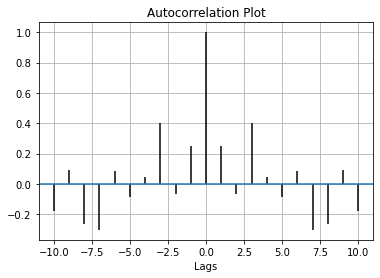

In [113]:
np.random.seed(42)
   
# Creating some random data.
data = np.random.randn(15)
   
# Adding plot title.
plt.title("Autocorrelation Plot")
 
# Providing x-axis name.
plt.xlabel("Lags")
 
# Plotting the Autocorrelation plot.
plt.acorr(data, maxlags = 10)
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show()

In [64]:
def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
        np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)

array1 = [[2],[1]]
array2 = [[2],[2]]
tensor1 = tf.convert_to_tensor(array1)
tensor2 = tf.convert_to_tensor(array2)
print(fid(tensor1,tensor1))

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'

In [59]:
import math
def bhattacharyya(a, b):
    """ Bhattacharyya distance between distributions (lists of floats). """
    if not len(a) == len(b):
        raise ValueError("a and b must be of the same size")
    return -math.log(sum((math.sqrt(u * w) for u, w in zip(a, b))))


x = bhattacharyya([0.1, 0.9], [0.1, 0.9])
print(x)

x = bhattacharyya([0.2, 0.8], [0.5, 0.5])
print(x)

x = bhattacharyya([0.1, 0.9], [0.5, 0.5])
print(x)

-0.0
0.05268025782891318
0.11157177565710491


In [28]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

array1 = [[2],[1]]
array2 = [[2],[2]]
tensor1 = tf.convert_to_tensor(array1)
tensor2 = tf.convert_to_tensor(array2)
print(MMD(tensor1,tensor2,0.1))

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 't'

In [32]:
import tensorflow as tf



def gaussian_kernel(x1, x2, beta = 0.1):
    r = tf.transpose(x1)
    r = tf.expand_dims(r, 2)
    return tf.reduce_sum(K.exp( -beta * K.square(r - x2)), axis=-1)
  
def MMD(x1, x2):
    """
    maximum mean discrepancy (MMD) based on Gaussian kernel
    function for keras models (theano or tensorflow backend)
    
    - Gretton, Arthur, et al. "A kernel method for the two-sample-problem."
    Advances in neural information processing systems. 2007.
    """
    x1x1 = gaussian_kernel(x1, x1)
    x1x2 = gaussian_kernel(x1, x2)
    x2x2 = gaussian_kernel(x2, x2)
    diff = tf.reduce_mean(x1x1) - 2 * tf.reduce_mean(x1x2) + tf.reduce_mean(x2x2)
    return diff

print(MMD([[1],[1]],[[2],[2]]))

TypeError: Cannot convert -0.1 to EagerTensor of dtype int32

In [41]:
'MMD functions'
def compute_kernel(x, y):
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1]
    tiled_x = K.tile(K.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = K.tile(K.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, 'float32'))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)

array1 = np.array([[2.1],[1.2]])
array2 = np.array([[2.1],[1.1]])
s = compute_mmd(array1,array2)

TypeError: x and y must have the same dtype, got tf.float64 != tf.float32

Autocorrelation

In [4]:
np.arange(5, 10)
np.arange(5)

array([0, 1, 2, 3, 4])

In [2]:

idx = np.random.randint(0, 10000)
print(idx)
days = list(range(idx-2,idx+1))
print(days)

6405
[6403, 6404, 6405]


In [5]:
list_a = [[1,2,3],[10,20,30]]
list_b = [[4,5,6,],[40,50,60]]
merged = np.column_stack([list_a,list_b])
print(merged)

[[ 1  2  3  4  5  6]
 [10 20 30 40 50 60]]


In [6]:
noise = np.concatenate(merged)
print(noise)

[ 1  2  3  4  5  6 10 20 30 40 50 60]


In [8]:
list = [1,2,3,4]
print(list[:-1])

[1, 2, 3]
